# Closed-loop experimentation with active learning

In this tutorial, you'll learn how to implement a complete closed-loop experiment using the AutoRA framework. 

In traditional active learning, we typically have a fixed pool of unlabeled data (e.g., images) that we want to label efficiently by selecting the most informative samples. In experimental design, however, we don't have a pre-existing pool of conditions - instead, we can **generate new experimental conditions on the fly** and collect observations from participants.

This leads us to **closed-loop experimentation**, where:
1. An **experimentalist** proposes new experimental conditions
2. An **experiment runner** collects observations at those conditions
3. A **theorist** (model) learns from the accumulated data
4. The cycle repeats, with the experimentalist using the current model to propose even better conditions

The AutoRA framework connects these three components:

![static/img/autora_workflow.png](static/img/autora_workflow.png)

(Image source: [autora](https://autoresearch.github.io/autora/))

In this tutorial, you will learn to:
- Set up the AutoRA experiment runner for the 2AFC task
- Implement a cyclic for-loop for closed-loop experimentation
- Collect data iteratively and fit models at each cycle
- Track model performance across cycles
- Understand how to integrate different experimentalist strategies

Let's get started!

## Library imports

In [13]:
import sys, os

import numpy as np
import pandas as pd

# Set the path to the project folder
target_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Adjust path as needed
if target_folder not in sys.path:
    sys.path.append(target_folder)
    
from resources.regressors import FFN, FFNRegressor

## Setting up the synthetic experiment

First, let's set up our synthetic 2AFC experiment with multiple synthetic participants. Each participant has their own cognitive model parameters that determine how they respond to different experimental conditions.

In [14]:
# Basic experiment parameters

n_units = 100  # Number of synthetic participants
noise_level = 0.3  # Measurement noise level

# Sample parameters for each synthetic participant
# Each participant has 2 parameters controlling their sensitivity to ratio and scatteredness
parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 0.1, parameters)  # Ensure positive parameters

print(f"Created {n_units} synthetic participants with individual cognitive parameters")
print(f"Example participant parameters: {parameters[0]}")

Created 100 synthetic participants with individual cognitive parameters
Example participant parameters: [1.11820418 0.73770858]


## Introduction to the AutoRA experiment runner

The AutoRA experiment runner is a wrapper around our 2AFC experiment that:
- Defines the **independent variables** (conditions we can control): participant_id, ratio, scatteredness
- Defines the **dependent variables** (observations we measure): response_time
- Provides a standardized interface for running experiments

Think of it as a way to package our experiment so it can be easily integrated into the closed-loop workflow.

Let's import and explore the experiment runner:

In [15]:
from resources.synthetic import twoafc

# Check the help documentation
help(twoafc)

Help on function twoafc in module resources.synthetic:

twoafc(parameters: numpy.ndarray, name='2AFC', resolution=100, minimum_value_condition: float = 0.0, maximum_value_condition: float = 1.0, noise_level: float = 0.0, discrete_iv: bool = False)
    2AFC experiment with two independent variables
    
    Args:
        parameters: abstract participant parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393



In [16]:
from autora.experiment_runner.synthetic.utilities import describe

# Create the experiment runner with our synthetic participants
experiment = twoafc(parameters=parameters, noise_level=noise_level)

# Describe the experiment structure
print(describe(experiment))


    2AFC experiment with two independent variables

    Args:
        parameters: abstract participant parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393
    


The experiment runner has two key methods:
- `experiment.run(conditions)`: Runs the experiment on specified conditions and returns observations
- `experiment.plotter()`: Visualizes the ground truth cognitive model and fitted model predictions

Let's test it by running a single condition:

Experiment result:
    unit_id  ratio  scatteredness  response_time
0         0      1              1       1.236511
1         1      1              1       1.080962
2         2      1              1       2.364898
3         3      1              1       1.768551
4         4      1              1       1.528207
..      ...    ...            ...            ...
95       95      1              1       1.862605
96       96      1              1       1.721218
97       97      1              1       1.673924
98       98      1              1       1.900544
99       99      1              1       2.252283

[100 rows x 4 columns]


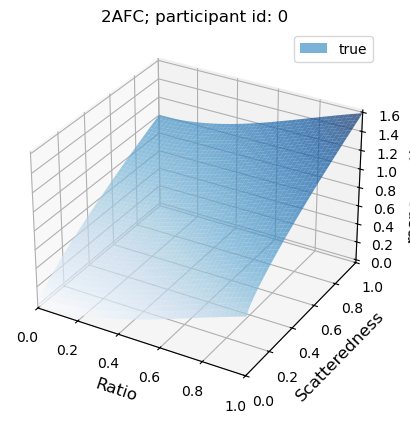

In [17]:
# Run the experiment on a single condition: [participant_id=0, ratio=1, scatteredness=1]
result = experiment.run(np.array([[1, 1]]), random_state=42)
print("Experiment result:")
print(result)

# Visualize the underlying ground truth for participant 0
experiment.plotter(participant_id=0)

## Setting up the closed-loop components

Now let's set up the three key components of our closed-loop experiment:

1. **Experiment runner**: We've already created this above (`experiment`)
2. **Experimentalist**: Proposes new experimental conditions to test
3. **Theorist**: A machine learning model that learns from the data

For the experimentalist, we'll start with a simple **random sampling** strategy that uniformly samples conditions from the experimental space.

In [18]:
from autora.experimentalist.random import random_pool

# Define the experimentalist (random sampling strategy)
experimentalist = random_pool

# Define the theorist (neural network model)
theorist = FFNRegressor(
    FFN(n_units=n_units, n_conditions=2),  # n_conditions=2 for ratio and scatteredness
    max_epochs=100,
    lr=0.1
)

print("Closed-loop components initialized:")
print(f"  Experiment: 2AFC task with {n_units} participants")
print(f"  Experimentalist: Random sampling")
print(f"  Theorist: Feed-forward neural network")

Closed-loop components initialized:
  Experiment: 2AFC task with 100 participants
  Experimentalist: Random sampling
  Theorist: Feed-forward neural network


## Understanding the variable structure

Before we start the loop, let's understand how the experiment variables are structured:

In [19]:
# Extract variable names from the experiment
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]

print("Independent variables (conditions):", iv_names)
print("Dependent variables (observations):", dv_names)

Independent variables (conditions): ['ratio', 'scatteredness']
Dependent variables (observations): ['response_time']


## Generating initial conditions

Every closed-loop experiment needs some initial conditions to start with. We'll use the experimentalist to generate an initial set of random conditions:

In [20]:
# Generate initial random conditions
n_samples = 100  # Number of conditions to sample per cycle

conditions = experimentalist(experiment.variables, n_samples).to_numpy()

print(f"Generated {len(conditions)} initial conditions")
print(f"Condition shape: {conditions.shape}")
print(f"First few conditions:")
print(conditions[:5])

Generated 100 initial conditions
Condition shape: (100, 2)
First few conditions:
[[0.05517375 0.84114682]
 [0.22489942 0.74129301]
 [0.53208594 0.22257833]
 [0.27994569 0.07784565]
 [0.23357763 0.55386584]]


## The closed-loop experimentation cycle

Now we're ready to implement the main closed-loop! 

Here's how each cycle works:

1. **Run experiment**: Collect observations at the current conditions
2. **Split data**: Divide into training and test sets
3. **Fit model**: Train the theorist on the training data
4. **Evaluate**: Test the model on held-out data
5. **Generate new conditions**: Use the experimentalist to propose new conditions
6. **Accumulate**: Add new conditions to the pool for the next cycle

This creates a **cyclic for-loop** where we continuously improve our model by collecting more data and refining our understanding.

Let's implement this:

In [21]:
# Closed-loop parameters
n_cycles = 1  # Number of cycles to run
train_ratio = 1.0  # Proportion of data to use for training (80% train, 20% test)

# Start the closed-loop experimentation cycle
for cycle in range(n_cycles):
    
    # Step 1: Run the experiment on current conditions
    experiment_data = experiment.run(conditions, shuffle=True).to_numpy()
    
    # Step 3: Fit the theorist on training data
    n_dv = len(experiment.variables.dependent_variables)
    X_train = experiment_data[:, :-n_dv]
    y_train = experiment_data[:, -n_dv:]
    
    theorist.fit(X=X_train, y=y_train)
    
    # Step 4: Evaluate the theorist on test data
    conditions_test = experimentalist(experiment.variables, num_samples=10000)
    experiment_data_test = experiment.run(conditions_test, noise_level_run=0).to_numpy()
    X_test = experiment_data_test[:, :-n_dv]
    y_test = experiment_data_test[:, -n_dv:]
    
    y_predicted = theorist.predict(X_test)
    mse = np.mean((y_test - y_predicted)**2)
    
    # Step 5: Generate new conditions for the next cycle
    new_conditions = experimentalist(experiment.variables, n_samples).to_numpy()
    
    # Step 6: Accumulate conditions for the next cycle
    conditions = np.concatenate((conditions, new_conditions))
    
    # Print progress
    print(f"Cycle {cycle+1}/{n_cycles}: Test MSE = {np.round(mse, 8)}")

print(f"\nClosed-loop completed! Total conditions tested: {len(conditions)}")


epoch	train loss
1/100	0.29290441
2/100	0.14411334
3/100	0.10746384
4/100	0.09827780
5/100	0.09522819
6/100	0.09411536
7/100	0.09389225
8/100	0.09294932
9/100	0.09312756
10/100	0.09317481
11/100	0.09255999
12/100	0.09267423
13/100	0.09307275
14/100	0.09244356
15/100	0.09150080
16/100	0.09308262
17/100	0.09360996
18/100	0.09163965
19/100	0.09152469
20/100	0.09107856
21/100	0.09002090
22/100	0.09079434
23/100	0.09024890
24/100	0.09118041
25/100	0.08986009
26/100	0.08919108
27/100	0.09035007
28/100	0.09041271
29/100	0.09046829
30/100	0.09179945
31/100	0.09095354
32/100	0.09130130
33/100	0.09009963
34/100	0.08875912
35/100	0.09063649
36/100	0.09064372
37/100	0.08937903
38/100	0.08901098
39/100	0.08824844
40/100	0.08948681
41/100	0.08830482
42/100	0.08801521
43/100	0.08967151
44/100	0.08854642
45/100	0.08882706
46/100	0.08787164
47/100	0.08681965
48/100	0.08638873
49/100	0.08643833
50/100	0.08895887
51/100	0.08985056
52/100	0.08902582
53/100	0.08717697
54/100	0.08623483
55/100	0.08633924
5

## Visualizing the results

Now let's visualize how well our trained model recovered the underlying cognitive model for a specific participant:

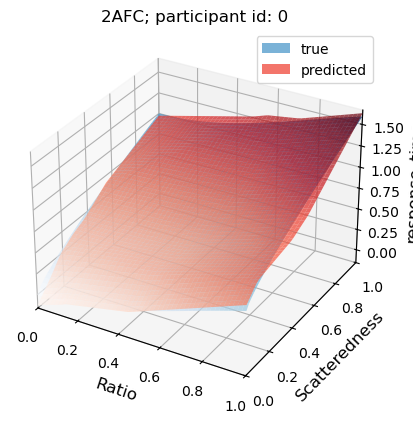

In [22]:
# Visualize the ground truth and model predictions for participant 0
experiment.plotter(
    participant_id=0,
    model=theorist,
)

The plot shows:
- **Blue surface**: The true underlying cognitive model
- **Red surface**: The neural network's learned predictions

How well does the model capture the true pattern? Try:
- Increasing `n_cycles` to see if more cycles improve the fit
- Changing `n_samples` to collect more/fewer conditions per cycle
- Adding noise by setting `noise_level > 0` at the beginning
- Testing different participants by changing `participant_id`

## Understanding the cyclic for-loop

The key advantage of this cyclic approach is its simplicity and transparency:

```python
for cycle in range(n_cycles):
    1. Run experiment on current conditions
    2. Split into train/test
    3. Fit model on training data
    4. Evaluate on test data
    5. Generate new conditions
    6. Accumulate conditions
```

Each step is explicit and easy to understand. You can:
- Add custom logging or visualization at any step
- Modify the data processing pipeline
- Integrate different experimentalist strategies
- Track additional metrics

This makes it perfect for learning and experimentation!

## Experimenting with different experimentalists

So far, we've used random sampling to propose new conditions. But AutoRA provides also other experimentalists like the **grid sampler**.

You can install them with:
```bash
pip install -U "autora[all-experimentalists]"
```

Or install specific ones:
```bash
pip install -U "autora[experimentalist-grid]"
```

Let's try using the **grid sampler** instead of random sampling:

In [23]:
from autora.experimentalist.grid import grid_pool

# Reset the experiment and theorist
experiment = twoafc(parameters, noise_level=noise_level, discrete_iv=True, resolution=10)
theorist = FFNRegressor(FFN(n_units=n_units, n_conditions=2), max_epochs=100, lr=0.1)

# Use grid sampling instead of random sampling
experimentalist = grid_pool
experimentalist_random = random_pool

# Generate initial grid conditions
conditions = experimentalist(experiment.variables).to_numpy()

print(f"Using grid sampling strategy")
print(f"First few grid conditions:")
print(conditions)

Using grid sampling strategy
First few grid conditions:
[[0.         0.        ]
 [0.         0.11111111]
 [0.         0.22222222]
 [0.         0.33333333]
 [0.         0.44444444]
 [0.         0.55555556]
 [0.         0.66666667]
 [0.         0.77777778]
 [0.         0.88888889]
 [0.         1.        ]
 [0.11111111 0.        ]
 [0.11111111 0.11111111]
 [0.11111111 0.22222222]
 [0.11111111 0.33333333]
 [0.11111111 0.44444444]
 [0.11111111 0.55555556]
 [0.11111111 0.66666667]
 [0.11111111 0.77777778]
 [0.11111111 0.88888889]
 [0.11111111 1.        ]
 [0.22222222 0.        ]
 [0.22222222 0.11111111]
 [0.22222222 0.22222222]
 [0.22222222 0.33333333]
 [0.22222222 0.44444444]
 [0.22222222 0.55555556]
 [0.22222222 0.66666667]
 [0.22222222 0.77777778]
 [0.22222222 0.88888889]
 [0.22222222 1.        ]
 [0.33333333 0.        ]
 [0.33333333 0.11111111]
 [0.33333333 0.22222222]
 [0.33333333 0.33333333]
 [0.33333333 0.44444444]
 [0.33333333 0.55555556]
 [0.33333333 0.66666667]
 [0.33333333 0.7777


epoch	train loss
1/100	0.28909618
2/100	0.13615416
3/100	0.10935165
4/100	0.10237200
5/100	0.10078294
6/100	0.09871758
7/100	0.09807416
8/100	0.09793045
9/100	0.09636248
10/100	0.09571014
11/100	0.09441135
12/100	0.09442843
13/100	0.09557561
14/100	0.09542736
15/100	0.09598731
16/100	0.09495855
17/100	0.09312168
18/100	0.09482725
19/100	0.09353962
20/100	0.09589760
21/100	0.09736094
22/100	0.09674859
23/100	0.09602339
24/100	0.09392518
25/100	0.09297432
26/100	0.09086250
27/100	0.09218196
28/100	0.09298175
29/100	0.09317083
30/100	0.09329196
31/100	0.09179768
32/100	0.09353832
33/100	0.09064582
34/100	0.09106706
35/100	0.09052161
36/100	0.09049119
37/100	0.09058016
38/100	0.09026832
39/100	0.08943062
40/100	0.08940901
41/100	0.09108256
42/100	0.09797495
43/100	0.09242302
44/100	0.08930573
45/100	0.08926748
46/100	0.09153765
47/100	0.09084463
48/100	0.09043594
49/100	0.08844357
50/100	0.08782199
51/100	0.08800694
52/100	0.09213858
53/100	0.09179920
54/100	0.09063793
55/100	0.08793509
5

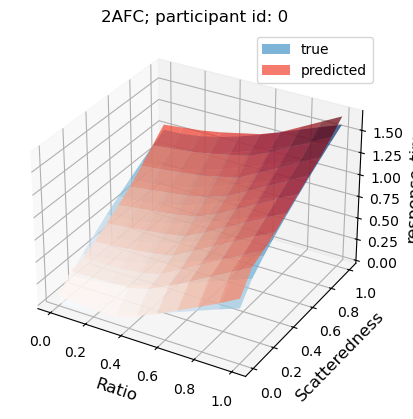

In [24]:
# Run the same closed-loop with grid sampling
for cycle in range(n_cycles):
    experiment_data = experiment.run(conditions, shuffle=True).to_numpy()
    
    n_dv = len(experiment.variables.dependent_variables)
    X_train = experiment_data[:, :-n_dv]
    y_train = experiment_data[:, -n_dv:]
    
    theorist.fit(X=X_train, y=y_train)
    
    conditions_test = experimentalist_random(experiment.variables, num_samples=10000)
    experiment_data_test = experiment.run(conditions_test, noise_level_run=0).to_numpy()
    X_test = experiment_data_test[:, :-n_dv]
    y_test = experiment_data_test[:, -n_dv:]
    
    y_predicted = theorist.predict(X_test)
    mse = np.mean((y_test - y_predicted)**2)
    
    new_conditions = experimentalist(experiment.variables).to_numpy()
    conditions = np.concatenate((conditions, new_conditions))
    
    print(f"Cycle {cycle+1}/{n_cycles} [Grid Sampling]: Test MSE = {np.round(mse, 8)}")

# Visualize results
experiment.plotter(participant_id=0, model=theorist)

Notice any differences between random and grid sampling?

Grid sampling provides more systematic coverage of the experimental space, which can be beneficial when you want to ensure even sampling across all regions.

## Congratulations!

You have completed all tutorials in the **Optimizing Experimental Design Course**! 

You've learned:
- How to set up synthetic experiments with cognitive models
- How to implement closed-loop experimentation with AutoRA
- How to integrate different experimentalist strategies
- How to evaluate model performance across cycles

AutoRA comes with many more sophisticated experimentalists:

- **Random**: Uniform random sampling (what we used)
- **Grid**: Systematic grid sampling
- **Novelty**: Samples conditions far from previous conditions
- **Inequality**: Samples where model predictions vary most
- **Nearest Value**: Samples near specific target values
- **Disagreement**: Samples where ensemble models disagree (requires ensemble)
- **Uncertainty**: Samples where model is most uncertain (requires ensemble)
- **Leverage**: Samples with high influence on model parameters
- **Falsification**: Samples likely to falsify current theory
- **Mixture**: Combines multiple strategies

In the next tutorials we are going to learn more about the **Uncertainty** and **Disagreement samplers**